# Feature Importance Using Decision Trees

In [1]:
import psycopg2 as pg
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Establish connection to postgres
conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

In [3]:
approach2CombinedTrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') OR (f."Season" < 2014) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2Combined_training = pd.read_sql_query(approach2CombinedTrainingDataQuery, conn)

In [4]:
approach2CombinedDevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2013) order by "Season", "DayNum", "Team" '''
df_approach2Combined_dev = pd.read_sql_query(approach2CombinedDevDataQuery, conn)

In [5]:
conn.close()

In [6]:
target = 'Outcome'
features = ['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor']

In [7]:
X_train2_combined = df_approach2Combined_training[features]
y_train2_combined = df_approach2Combined_training[target]
X_dev2_combined  = df_approach2Combined_dev[features]
y_dev2_combined  = df_approach2Combined_dev[target]

In [8]:
rows_to_drop = (np.isnan(df_approach2Combined_training.Outcome)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.AvgRank)) | (np.isnan(df_approach2Combined_training.OpponentAvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentWinPct)) | (np.isnan(df_approach2Combined_dev.WinPctDiff)) | (np.isnan(df_approach2Combined_dev.AvgPointsFor)) | (np.isnan(df_approach2Combined_dev.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.OpponentAvgNetPointsFor))

In [9]:
df_approach2Combined_training = df_approach2Combined_training.drop(df_approach2Combined_training[rows_to_drop].index)

In [10]:
rows_to_drop = (np.isnan(df_approach2Combined_dev.Outcome)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.AvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentAvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentWinPct)) | (np.isnan(df_approach2Combined_dev.WinPctDiff)) | (np.isnan(df_approach2Combined_dev.AvgPointsFor)) | (np.isnan(df_approach2Combined_dev.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.OpponentAvgNetPointsFor))

In [11]:
df_approach2Combined_dev = df_approach2Combined_dev.drop(df_approach2Combined_dev[rows_to_drop].index)

In [12]:
reduced_features = ['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'AvgRank', 'OpponentAvgRank', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor']

In [13]:
X_train2_combined = df_approach2Combined_training[reduced_features]
y_train2_combined = df_approach2Combined_training[target]
X_dev2_combined  = df_approach2Combined_dev[reduced_features]
# Cast to 'int'
y_dev2_combined  = df_approach2Combined_dev[target].astype(int)

In [45]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

## Decision Tree: Feature Importance for Regular Season

In [46]:
dt.fit(X_train2_combined, y_train2_combined)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

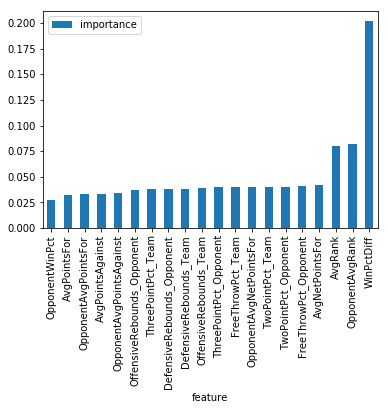

In [47]:
importance_df = pd.DataFrame({
        'feature': reduced_features,
        'importance': dt.feature_importances_
    })
importance_df.sort_values(by='importance').plot(x='feature', kind='bar')

In [48]:
importance_df.sort_values(by='importance', ascending=False)

,feature,importance
13,WinPctDiff,0.202039
11,OpponentAvgRank,0.081835
10,AvgRank,0.080330
16,AvgNetPointsFor,0.041737
7,FreeThrowPct_Opponent,0.041223
5,TwoPointPct_Opponent,0.040502
0,TwoPointPct_Team,0.040495
19,OpponentAvgNetPointsFor,0.040332
2,FreeThrowPct_Team,0.040318
6,ThreePointPct_Opponent,0.040180


## Decision Tree: Feature Importance for Combined Reg Season / Tournament

In [49]:
dt.fit(X_dev2_combined, y_dev2_combined)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

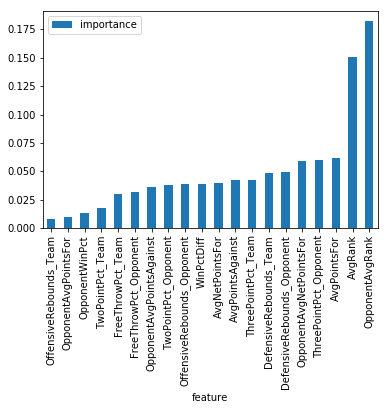

In [50]:
importance_df = pd.DataFrame({
        'feature': reduced_features,
        'importance': dt.feature_importances_
    })
importance_df.sort_values(by='importance').plot(x='feature', kind='bar')

In [51]:
importance_df.sort_values(by='importance', ascending=False)

,feature,importance
11,OpponentAvgRank,0.182394
10,AvgRank,0.150885
14,AvgPointsFor,0.061837
6,ThreePointPct_Opponent,0.059805
19,OpponentAvgNetPointsFor,0.059446
9,DefensiveRebounds_Opponent,0.049538
4,DefensiveRebounds_Team,0.048569
1,ThreePointPct_Team,0.042635
15,AvgPointsAgainst,0.042028
16,AvgNetPointsFor,0.039676


#### Remarks:
WinPctDiff makes a difference in the regular season, but does not in the tournament.  
There is a different set of (less) important features in the tournament.

In [52]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, oob_score=True)

## Random Forest: Feature Importance for Regular Season

In [53]:
rf.fit(X_train2_combined, y_train2_combined)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

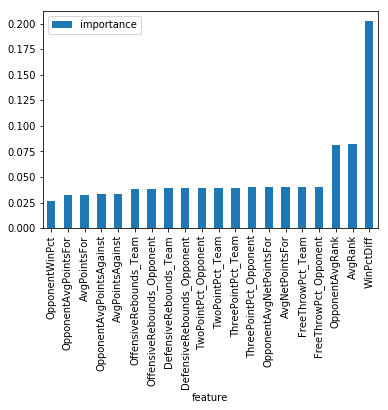

In [54]:
importance_df = pd.DataFrame({
        'feature': reduced_features,
        'importance': rf.feature_importances_
    })
importance_df.sort_values(by='importance').plot(x='feature', kind='bar')

In [55]:
importance_df.sort_values(by='importance', ascending=False)

,feature,importance
13,WinPctDiff,0.202703
10,AvgRank,0.081818
11,OpponentAvgRank,0.081712
7,FreeThrowPct_Opponent,0.040437
2,FreeThrowPct_Team,0.040413
16,AvgNetPointsFor,0.040406
19,OpponentAvgNetPointsFor,0.040127
6,ThreePointPct_Opponent,0.039713
1,ThreePointPct_Team,0.039646
0,TwoPointPct_Team,0.039566


## Random Forest: Feature Importance for Combined Reg Season / Tournament

In [56]:
rf.fit(X_dev2_combined, y_dev2_combined)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

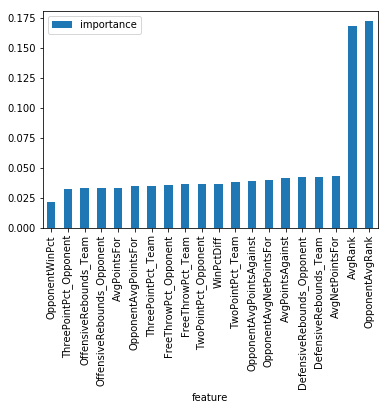

In [57]:
importance_df = pd.DataFrame({
        'feature': reduced_features,
        'importance': rf.feature_importances_
    })
importance_df.sort_values(by='importance').plot(x='feature', kind='bar')

In [58]:
importance_df.sort_values(by='importance', ascending=False)

,feature,importance
11,OpponentAvgRank,0.172508
10,AvgRank,0.168157
16,AvgNetPointsFor,0.043561
4,DefensiveRebounds_Team,0.042928
9,DefensiveRebounds_Opponent,0.042414
15,AvgPointsAgainst,0.041904
19,OpponentAvgNetPointsFor,0.039942
18,OpponentAvgPointsAgainst,0.038992
0,TwoPointPct_Team,0.038604
13,WinPctDiff,0.036912


#### Remarks:
WinPctDiff makes a difference in the regular season, but does not in the tournament.  
There is a different set of (less) important features in the tournament.